In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))

In [2]:
suppressMessages(source("lib/R/bio_utils.R"))
suppressMessages(source("lib/R/data_utils.R"))
suppressMessages(source("lib/R/plots.R"))

In [3]:
options(jupyter.plot_scale = 1)

In [4]:
# Notebook inputs
c_snv_list <- "data/snv_list.csv"
c_signatures <- "data/signatures.csv"
c_contributions <- "data/contributions.csv"
c_extraction_stats <- "data/statistics.csv"
c_selected_signatures <- c("SBS1", "SBS3", "SBS5", "SBS6", "SBS9", "SBS84")
c_cosmic_genome <- "GRCh38"
c_cosmic_version <- 3.2

In [5]:
# Load SNVs
df <- read.csv(c_snv_list, stringsAsFactors = FALSE)

# 1. Mutational Matrix

## 1.1. Mutational Profile

This corresponds to the representation of the RAW counts classified by substitution and context.

In [6]:
# Make mutation tables for all snv and only ig ones
mutation_table_full <- make_mutation_table(df, lymph)
mutation_table_ig <-
  make_mutation_table(df %>% filter(ig == "True"), lymph) %>%
  dplyr::rename("IG CLL/MBL" = "CLL/MBL", "IG FL" = "FL")

# Combine mutation tables
mutation_table <-
  merge(mutation_table_full, mutation_table_ig, all = TRUE) %>%
  replace(is.na(.), 0)

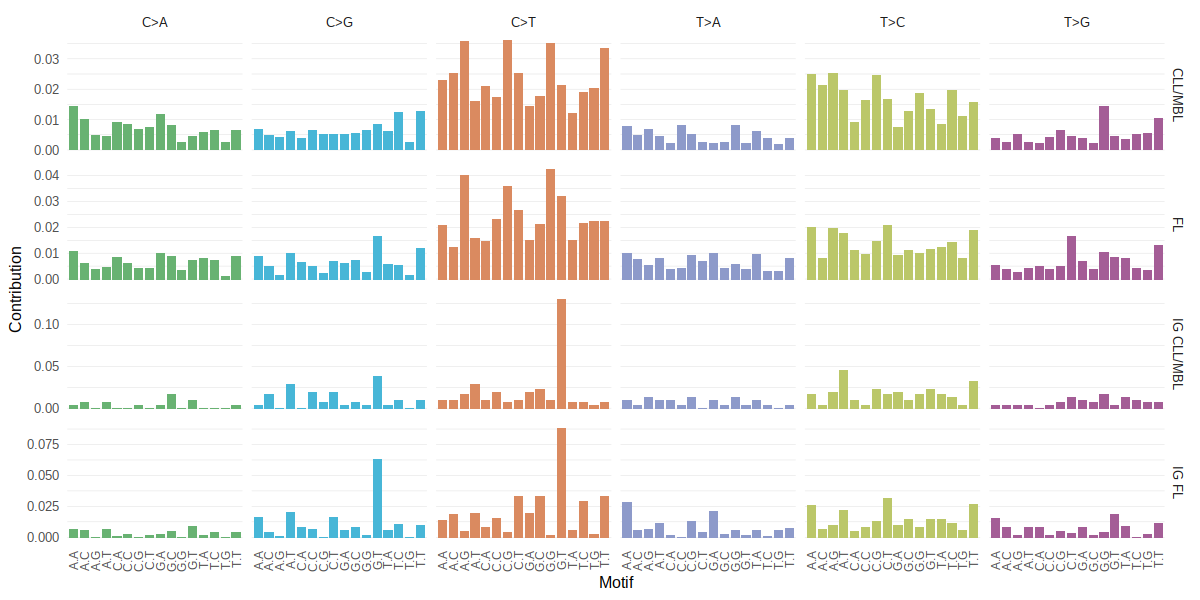

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5)
print(plot_patterns_96(mutation_table))

# 2. Signature Extraction

## 2.1. Extraction Statistics

SigProfiler collects two metrics for each number of signatures extracted, these are:
- Average stability: 

In [8]:
# Read extraction stats
extraction_stats <- read.csv(c_extraction_stats, stringsAsFactors = FALSE)

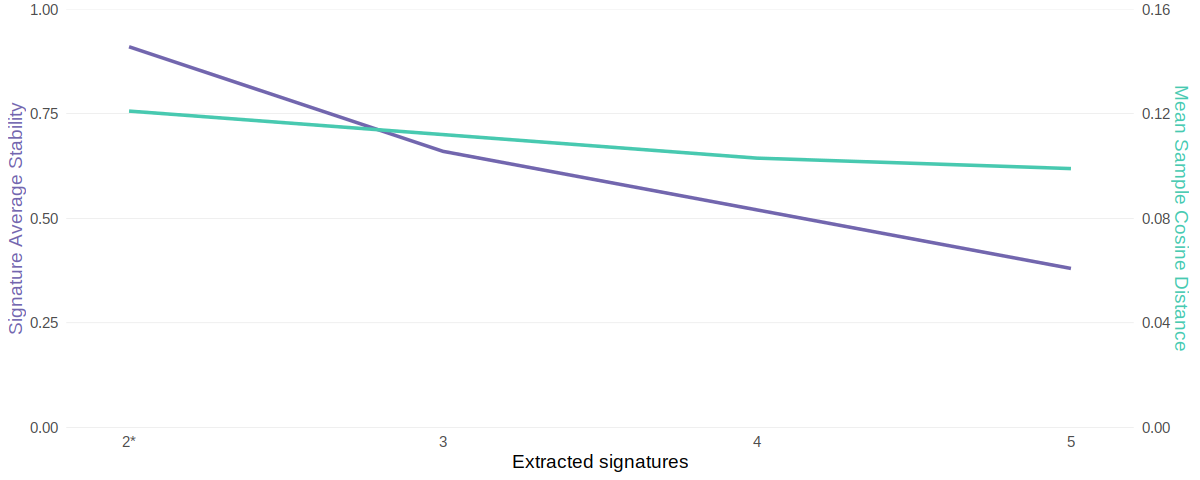

In [9]:
options(repr.plot.width = 10, repr.plot.height = 4)
print(plot_extraction_statistics(extraction_stats))

## 2.2. Signatures

In [10]:
# load signatures
signatures <- read.csv(c_signatures) %>%
  dplyr::mutate(X = sub("^(.)\\[(.>.)\\](.)$", "\\2 \\1.\\3", mutation)) %>%
  tidyr::separate(X, c("substitution", "context"), " ") %>%
  dplyr::select(substitution, context, everything(), -mutation)

contributions <- read.csv(c_contributions) %>%
  tidyr::gather("signature", "contribution", -sample) %>%
  dplyr::group_by(sample) %>%
  dplyr::mutate(contribution = contribution / sum(contribution))

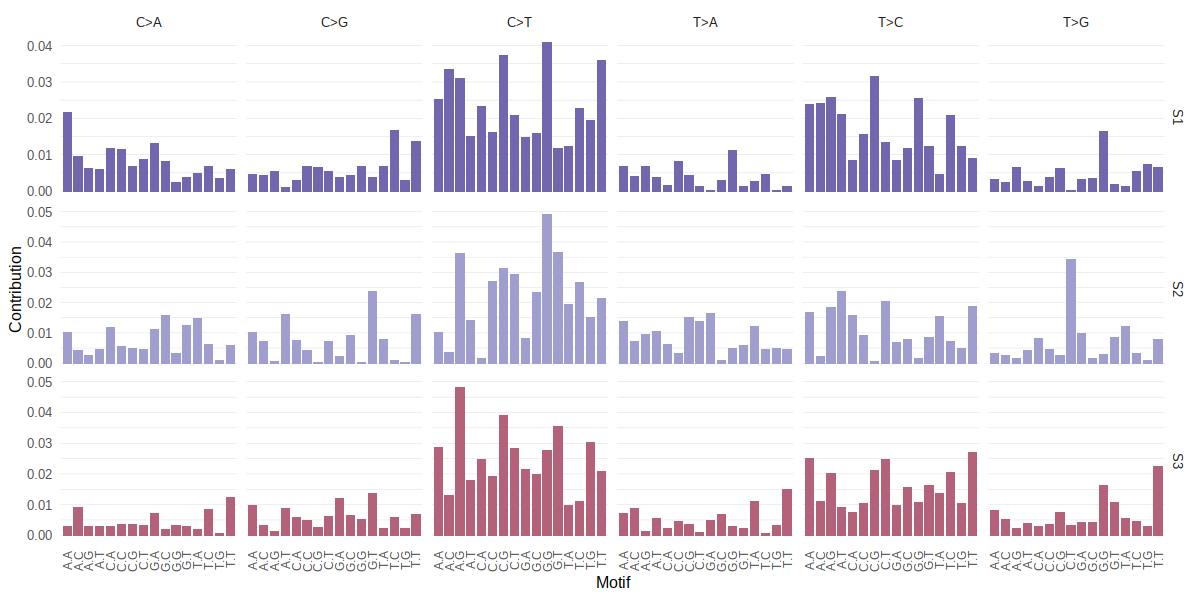

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
print(plot_patterns_96(signatures, colorby = "sample"))

## 2.3. Signature Contribution

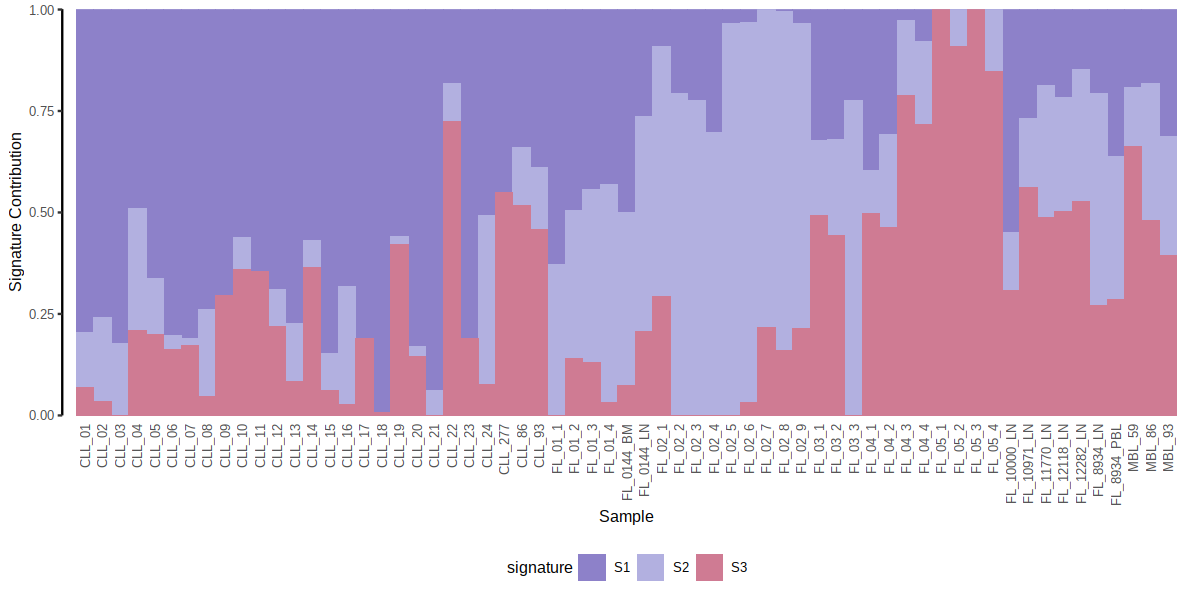

In [12]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_signature_contributions(contributions, from_extraction = TRUE)

# 3. Comparison Against Reference Signatures

## 3.1. Sample Fitting

In [13]:
signatures_cosmic <- get_cosmic_signatures(version = c_cosmic_version, genome = c_cosmic_genome)
signatures_cosmic_subset <- signatures_cosmic %>%
  dplyr::select(mutation, substitution, context, dplyr::one_of(c_selected_signatures))

mt <- df %>%
  make_mutation_table(sample) %>%
  dplyr::mutate(mutation = format_mutation(substitution, context))

In [14]:
fitting_table <- fit_signatures(mt, signatures_cosmic_subset)

In [15]:
# make hierarchical cluster using DIANA
fitting_hclust <- fitting_clustering(fitting_table)
# reorder samples according to clustering result
fitting_table <- fitting_table %>%
  dplyr::mutate(sample = factor(sample, levels = fitting_hclust$order.lab))

Warning message in if (color == "cluster") color <- "default":
“la condición tiene longitud > 1 y sólo el primer elemento será usado”


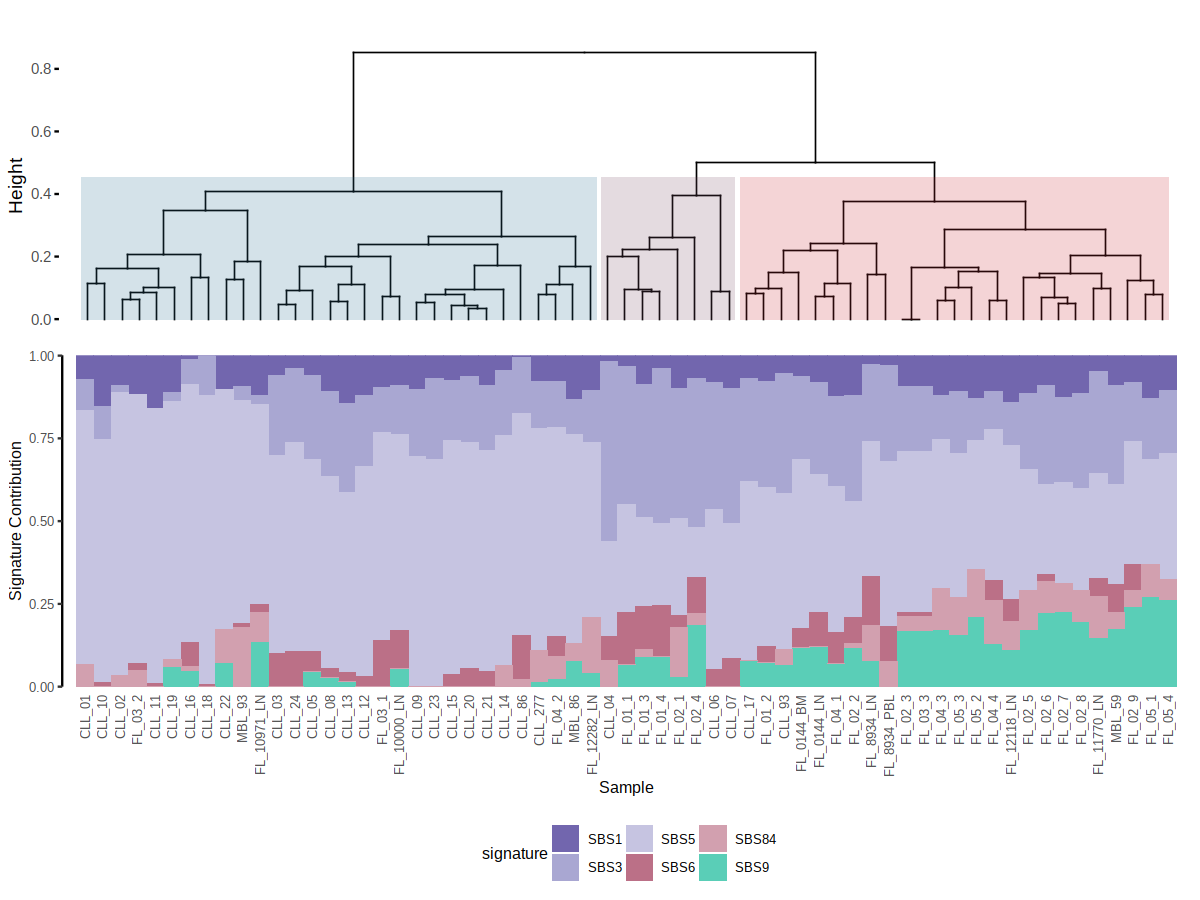

In [16]:
options(repr.plot.width = 10, repr.plot.height = 7.5)
plot_fitting_dend <- plot_hclust(fitting_hclust)
plot_fitting_contrib <- plot_signature_contributions(fitting_table, from_extraction = FALSE)
print(plot_grid(plot_fitting_dend, plot_fitting_contrib, nrow = 2, rel_heights = c(1, 1.6)))

# 3.2 Signature Reconstruction

In [17]:
dir.create("output/reconstruction/", recursive = TRUE, showWarnings = FALSE)
for (s in names(signatures) %>% purrr::discard(~ . %in% c("substitution", "context", "mutation"))) {
  reconstruction <- reconstruct_signatures(signatures[[s]], signatures_cosmic)

  # print top hits
  print(glue::glue("Top combinations {s}:"))
  print(head(reconstruction))
  cat("\n")

  # save full list
  write.csv(reconstruction, glue::glue("output/reconstruction/{s}.csv"))
}

Top combinations S1:
        name          proportions        similarity
1  SBS1+SBS5    SBS1=0.1;SBS5=0.9 0.907752268146236
2  SBS5+SBS6  SBS5=0.85;SBS6=0.15 0.894658672670608
3 SBS5+SBS87 SBS5=0.85;SBS87=0.15 0.889249105126781
4 SBS5+SBS15 SBS5=0.89;SBS15=0.11 0.881795940051218
5 SBS5+SBS50 SBS5=0.91;SBS50=0.09 0.862861657296494
6 SBS5+SBS51 SBS5=0.91;SBS51=0.09 0.862424346763255

Top combinations S2:
        name          proportions        similarity
1 SBS6+SBS40 SBS6=0.26;SBS40=0.74 0.845187790445203
2 SBS5+SBS15 SBS5=0.81;SBS15=0.19 0.842592000851415
3  SBS3+SBS6  SBS3=0.75;SBS6=0.25 0.838038742126963
4  SBS1+SBS5  SBS1=0.12;SBS5=0.88 0.837338188760445
5  SBS5+SBS6  SBS5=0.79;SBS6=0.21 0.834261008055434
6 SBS1+SBS40 SBS1=0.15;SBS40=0.85 0.829914249006045

Top combinations S3:
        name          proportions        similarity
1  SBS1+SBS5  SBS1=0.13;SBS5=0.87 0.913996736236059
2  SBS5+SBS6    SBS5=0.8;SBS6=0.2 0.898515563653582
3 SBS5+SBS87   SBS5=0.8;SBS87=0.2 0.889060232015722